In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns 

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import shap
shap.initjs()

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
df_train = pd.read_csv('all/train_V2.csv')

#### Delete Missing Value

In [3]:
df_train.dropna(subset=['winPlacePerc'], inplace=True)

#### Delete Games with 0 and 1 player

In [4]:
df_train = df_train[df_train['maxPlace'] > 1]

# Map and Gametype Features

### Gametypes coding

In [6]:
game_name_dic = {
    "solo": "solo", "solo-fpp": "solo", 'normal-solo': "solo", "normal-solo-fpp": "solo",
    "duo": "duo", "duo-fpp": "duo", 'normal-duo': "duo","normal-duo-fpp": "duo",
    "squad": "squad", "squad-fpp": "squad", 'normal-squad': "squad","normal-squad-fpp": "squad",
    "crashfpp": "crash", "crashtpp": "crash",
    "flarefpp": "flare", "flaretpp": "flare"
      }

In [7]:
df_train['matchTypeName'] = df_train['matchType'].apply(lambda x: game_name_dic[x])

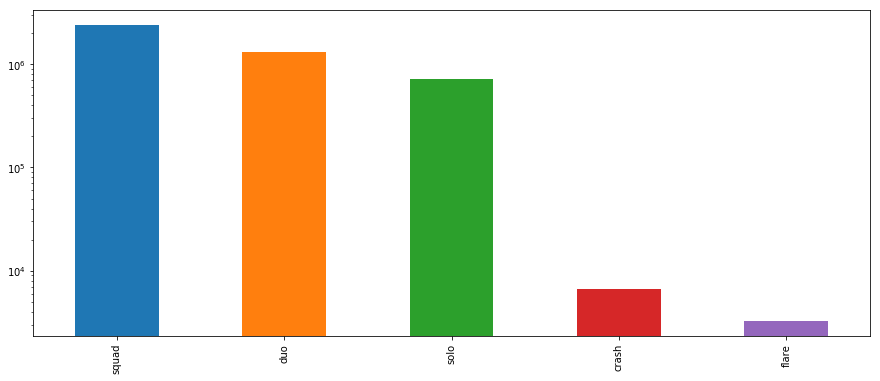

In [8]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set(yscale="log")
df_train['matchTypeName'].value_counts().sort_values(ascending=False).plot.bar(ax=ax)
plt.show()

### Played map

/Users/marcel/anaconda3/envs/ML_Setup/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


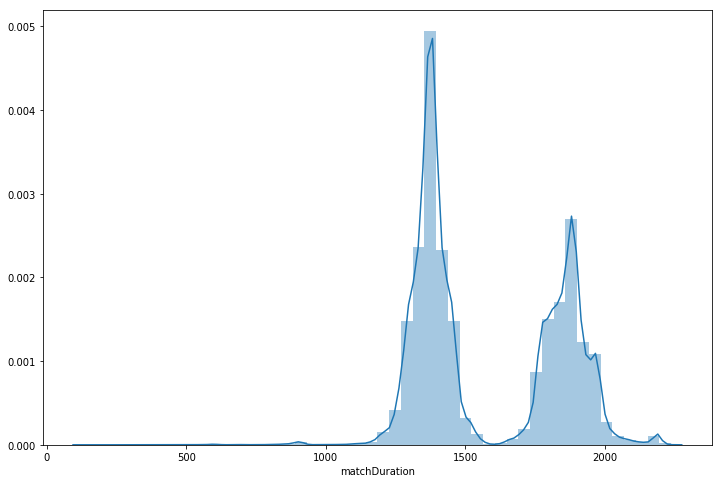

In [10]:
plt.figure(figsize=(12,8))
sns.distplot(df_train['matchDuration'])
plt.show()

In [11]:
def get_map(x):
    if x > 1600:
        return 0
    else: 
        return 1

In [12]:
df_train['miniRoyale'] = df_train['matchDuration'].transform(get_map)

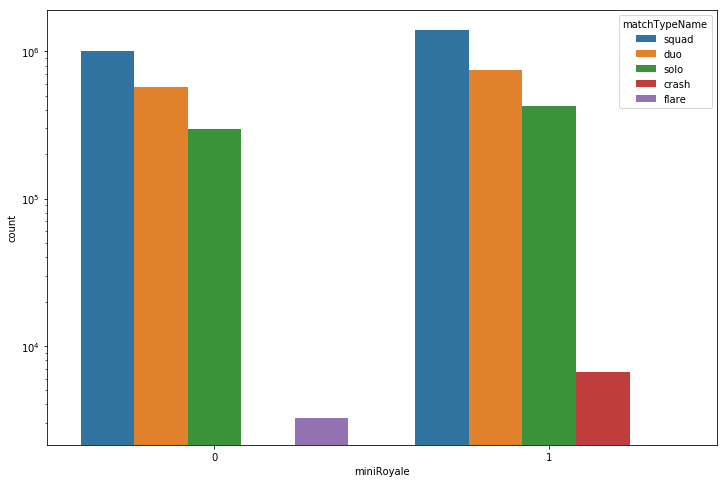

In [13]:
data = df_train
f, ax = plt.subplots(figsize=(12, 8))
ax.set(yscale="log")
sns.countplot(x='miniRoyale', hue='matchTypeName', ax=ax, data=data, palette=sns.color_palette(n_colors=5))
plt.show()

# Player based features

### Distance per Duration

In [15]:
df_train['total_distance'] = df_train.rideDistance + df_train.swimDistance + df_train.walkDistance

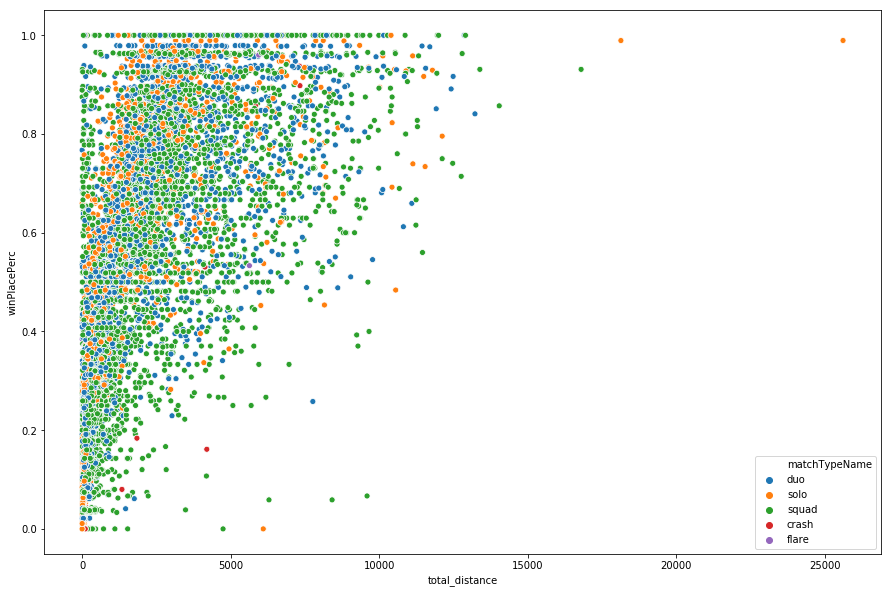

In [16]:
data = df_train.sample(10000)
plt.figure(figsize=(15,10))
sns.scatterplot(x='total_distance', y='winPlacePerc', hue='matchTypeName', data=data, 
                palette=sns.color_palette(n_colors=5))
plt.show()

In [17]:
df_train['distance_per_duration'] = df_train['total_distance']/df_train['matchDuration']

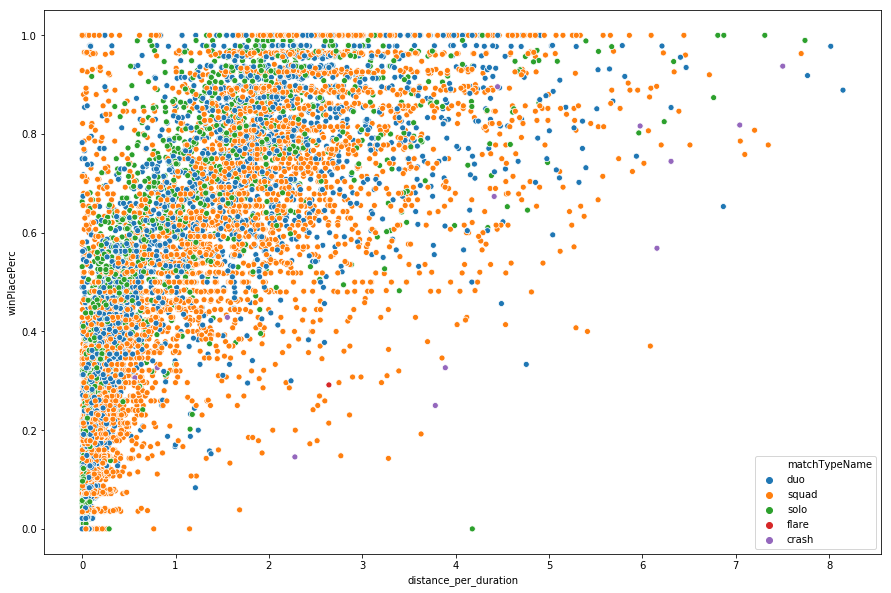

In [18]:
data = df_train.sample(10000)
plt.figure(figsize=(15,10))
sns.scatterplot(x='distance_per_duration', y='winPlacePerc', hue='matchTypeName', data=data, 
                palette=sns.color_palette(n_colors=5))
plt.show()

### Items acquired and items per Duration

In [19]:
df_train['total_items_acquired'] = df_train.boosts + df_train.heals + df_train.weaponsAcquired

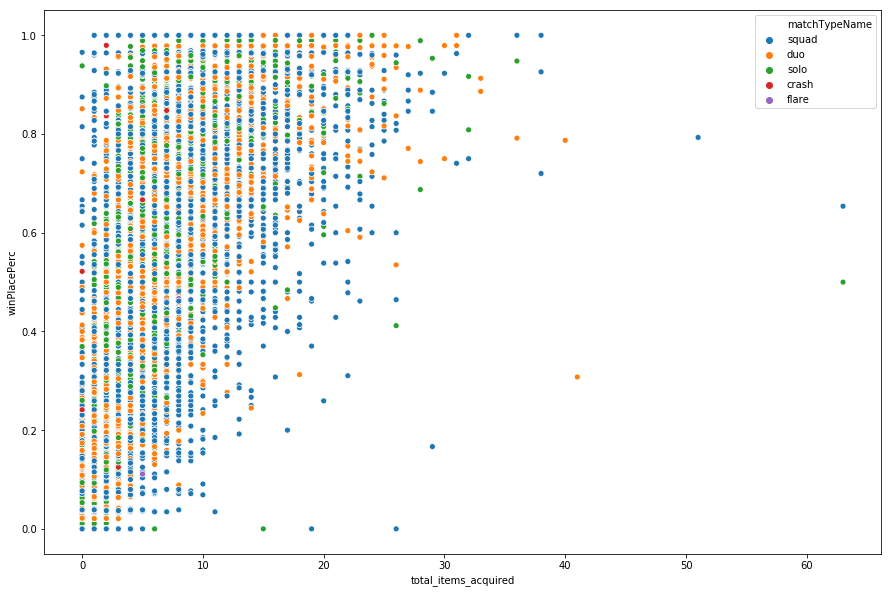

In [20]:
data = df_train.sample(10000)
plt.figure(figsize=(15,10))
sns.scatterplot(x='total_items_acquired', y='winPlacePerc', hue='matchTypeName', 
                data=data, palette=sns.color_palette(n_colors=5))
plt.show()

In [21]:
df_train['items_per_duration'] = df_train['total_items_acquired'] / df_train['matchDuration']
df_train['items_per_duration'].fillna(0, inplace=True)
df_train['items_per_duration'].replace(np.inf, 0, inplace=True)

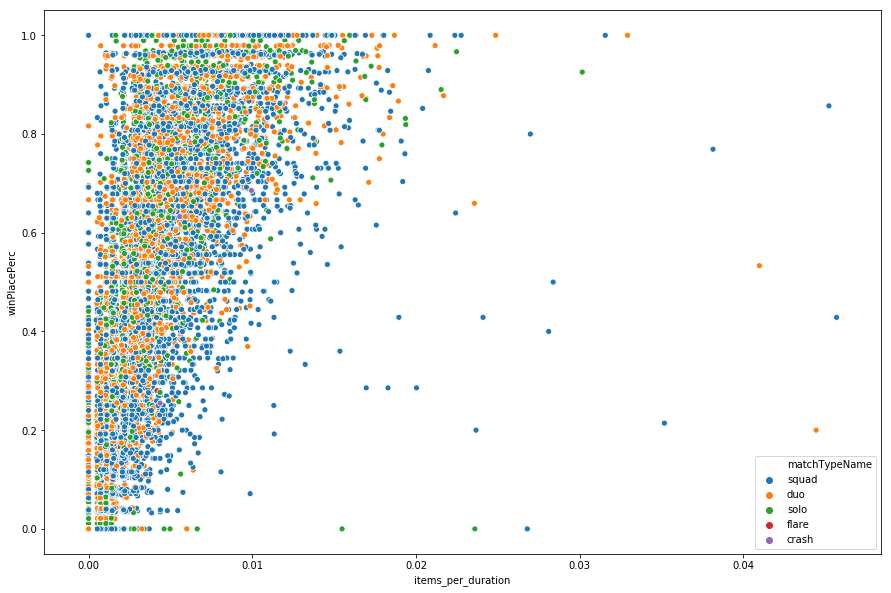

In [22]:
data = df_train.sample(10000)
plt.figure(figsize=(15,10))
sns.scatterplot(x='items_per_duration', y='winPlacePerc', hue='matchTypeName', 
                data=data, palette=sns.color_palette(n_colors=5))
plt.show()

### Impact per Duration

In [23]:
df_train['total_impact'] = df_train['kills'] + df_train['assists'] + df_train['damageDealt']

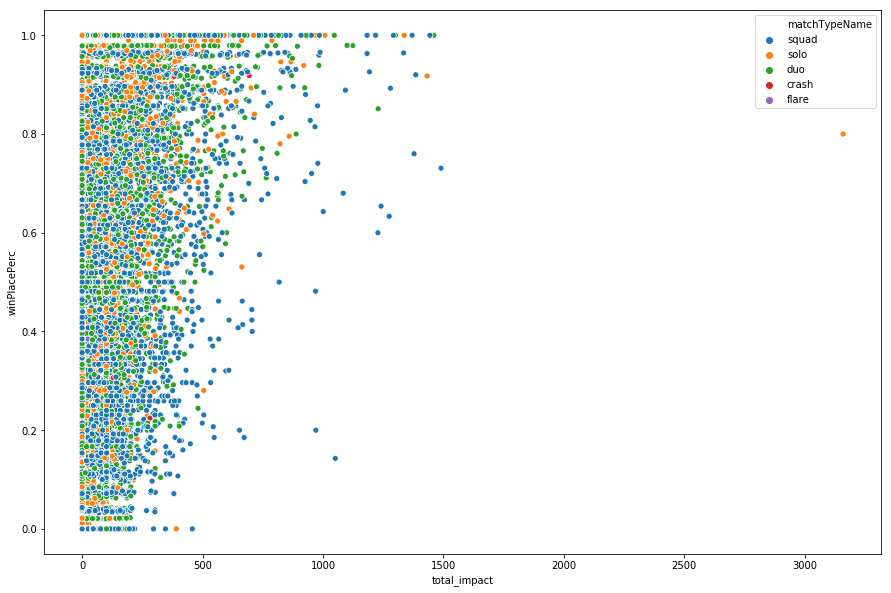

In [24]:
data = df_train.sample(10000)
plt.figure(figsize=(15,10))
sns.scatterplot(x='total_impact', y='winPlacePerc', hue='matchTypeName', 
                data=data, palette=sns.color_palette(n_colors=5))
plt.show()

In [25]:
df_train['impact_per_duration'] = df_train['total_impact'] / df_train['matchDuration']

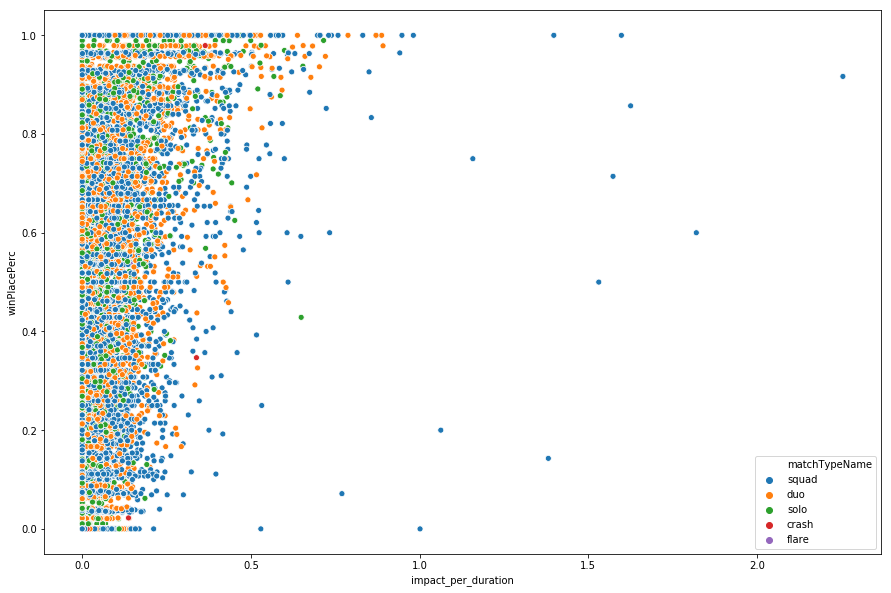

In [26]:
data = df_train.sample(10000)
plt.figure(figsize=(15,10))
sns.scatterplot(x='impact_per_duration', y='winPlacePerc', hue='matchTypeName', 
                data=data, palette=sns.color_palette(n_colors=5))
plt.show()

### Skill implicit

In [27]:
df_train['skill_implicit'] = (df_train['headshotKills'] + df_train['longestKill'] + \
                              df_train['revives'] + df_train['roadKills'] + \
                              df_train['killStreaks'] - \
                              df_train['teamKills'] - df_train['DBNOs']) / \
                              df_train['matchDuration']

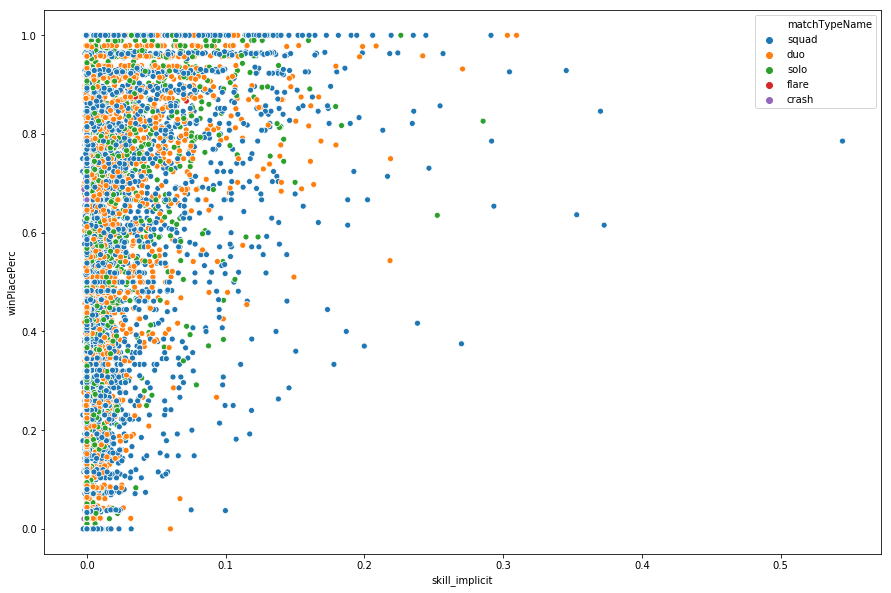

In [28]:
data = df_train.sample(10000)
plt.figure(figsize=(15,10))
sns.scatterplot(x='skill_implicit', y='winPlacePerc', hue='matchTypeName', 
                data=data, palette=sns.color_palette(n_colors=5))
plt.show()

In [29]:
feature_cols.extend(['total_distance', 'distance_per_duration', 'items_per_duration', 
                     'impact_per_duration', 'skill_implicit'])

# Team Features

### Team Size

In [50]:
df_train = df_train.assign(team_size=df_train.groupby(['matchId','groupId']).groupId.transform('count'))

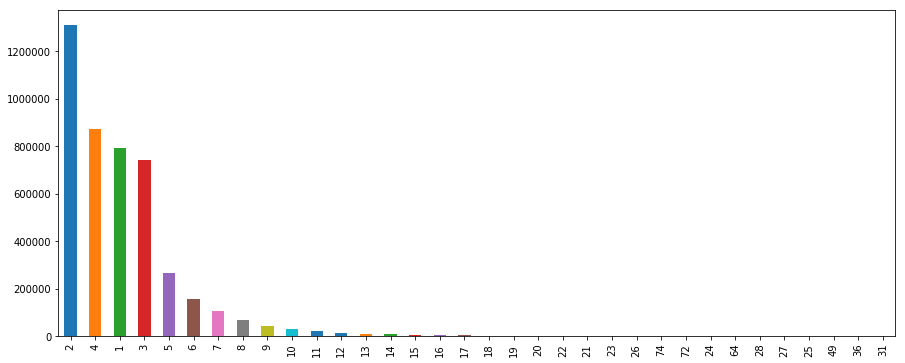

In [51]:
f, ax = plt.subplots(figsize=(15, 6))
df_train['team_size'].value_counts().sort_values(ascending=False).plot.bar()
plt.show()

### Other Features

In [32]:
df_train['rankPoints'] = np.where(df_train['rankPoints'] <= 0 ,0 , df_train['rankPoints'])

In [33]:
df_train['winPoints'] = np.where(df_train['winPoints'] <= 0 ,0 , df_train['winPoints'])

In [34]:
features = ['total_distance', 'total_items_acquired', 'total_impact', 'skill_implicit', 
            'rankPoints', 'winPoints', 'killPlace', 'maxPlace']

In [44]:
for f in features:
    #maximum
    print("Feature: ", f)
    agg_name = 'max_' + f + '_by_team'
    rank_name = 'max_' + f + '_by_team_rank'

    agg = df_train.groupby(['matchId', 'groupId'])[f].agg('max')
    rank_agg = agg.groupby('matchId').rank(pct=True)
    
    agg.rename(agg_name, inplace=True)
    rank_agg.rename(rank_name, inplace=True)
    
    df_train = df_train.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_train = df_train.merge(rank_agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])

    #minimum
    agg_name = 'min_' + f + '_by_team'
    rank_name = 'min_' + f + '_by_team_rank'

    agg = df_train.groupby(['matchId', 'groupId'])[f].agg('min')
    rank_agg = agg.groupby('matchId').rank(pct=True)
    
    agg.rename(agg_name, inplace=True)
    rank_agg.rename(rank_name, inplace=True)
    
    df_train = df_train.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_train = df_train.merge(rank_agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    
    #mean
    agg_name = 'mean_' + f + '_by_team'
    rank_name = 'mean_' + f + '_by_team_rank'

    agg = df_train.groupby(['matchId', 'groupId'])[f].agg('mean')
    rank_agg = agg.groupby('matchId').rank(pct=True)
    
    agg.rename(agg_name, inplace=True)
    rank_agg.rename(rank_name, inplace=True)
    
    df_train = df_train.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_train = df_train.merge(rank_agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])

Feature:  total_distance
Feature:  total_items_acquired
Feature:  total_impact
Feature:  skill_implicit
Feature:  rankPoints
Feature:  winPoints


In [45]:
df_train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'matchTypeName',
       'miniRoyale', 'total_distance', 'distance_per_duration',
       'total_items_acquired', 'items_per_duration', 'total_impact',
       'impact_per_duration', 'skill_implicit', 'team_size',
       'max_total_distance_by_team', 'max_total_distance_by_team_rank',
       'min_total_distance_by_team', 'min_total_distance_by_team_rank',
       'mean_total_distance_by_team', 'mean_total_distance_by_team_rank',
       'max_total_items_acquired_by_team',
       'max_total_items_acquired_by_team_rank',
       'min_total_items_acquired_by_team',
       'm

### Kills by Team

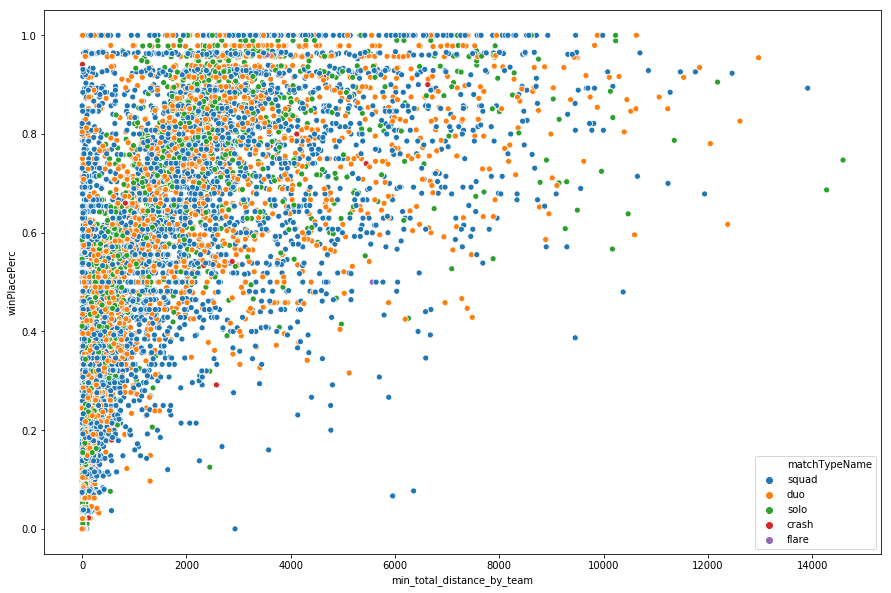

In [47]:
data = df_train.sample(10000)
plt.figure(figsize=(15,10))
sns.scatterplot(x='min_total_distance_by_team', y='winPlacePerc', hue='matchTypeName', 
                data=data, palette=sns.color_palette(n_colors=5))
plt.show()

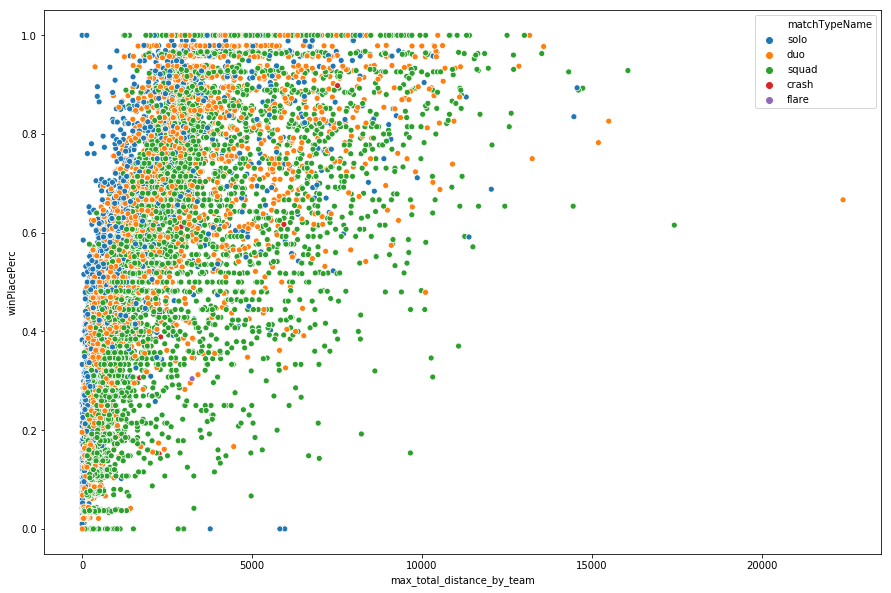

In [48]:
data = df_train.sample(10000)
plt.figure(figsize=(15,10))
sns.scatterplot(x='max_total_distance_by_team', y='winPlacePerc', hue='matchTypeName', 
                data=data, palette=sns.color_palette(n_colors=5))
plt.show()

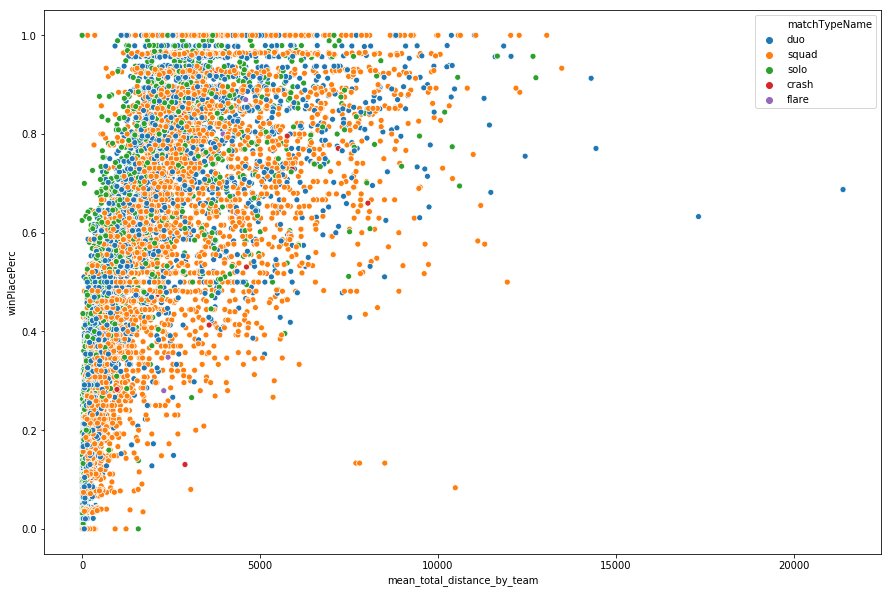

In [49]:
data = df_train.sample(10000)
plt.figure(figsize=(15,10))
sns.scatterplot(x='mean_total_distance_by_team', y='winPlacePerc', hue='matchTypeName', 
                data=data, palette=sns.color_palette(n_colors=5))
plt.show()

## Save Processed Data

In [ ]:
df_train.to_csv('all/train_V2_processed.csv')